In [6]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import grad, hessian, jit, vmap
from jax.nn import celu
import gvar as gv
from functools import partial
from IPython.display import clear_output
import jax.example_libraries.optimizers as jax_opt
from tqdm import trange

#TODO: plot relative error against the number of parameters

num_particles = 2
structure = [20, 50, 100, 200, 100, 50, 20]
num_nodes = np.sum(structure)
m = 1
hbar = 1
omega = 1
harmonic_omega = 1
g = 1
sigma = -g/2

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Initialize weights and biases for each layer
        self.weights = []
        self.biases = []
        if hidden_sizes != [0]:
            sizes = [input_size] + hidden_sizes + [output_size]
        else:
            sizes = [input_size, output_size]

        for i in range(len(sizes) - 1):
            w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
            b = np.random.randn(1, sizes[i+1]) 
            self.weights.append(w)
            self.biases.append(b)

    @partial(jit, static_argnums=(0,))
    def transform(self, coords):
       # if running into NaNs, try to increase this
        C = 2
        ret = jnp.zeros(num_particles)
        for i in range(num_particles):
            ret = ret.at[i].set(jnp.sum(jnp.power(coords/C, i + 1)))
        return ret 

    @partial(jit, static_argnums=(0,))
    def __call__(self, x, params):
        x = self.transform(x)
        self.weights, self.biases = self.unflatten_params(params)
        a = x
        for i in range(len(self.weights) - 1):
            z = jnp.dot(a, self.weights[i]) + self.biases[i]
            a = celu(z)
        a = jnp.dot(a, self.weights[-1]) + self.biases[-1]
        return a[0][0]
    
    @partial(jit, static_argnums=(0,))
    def flatten_params(self):
        params = jnp.array([])
        for i in range(len(self.weights)):
            params = jnp.concatenate((params, self.weights[i].flatten()))
            params = jnp.concatenate((params, self.biases[i].flatten()))
        return jnp.array(params)
    
    @partial(jit, static_argnums=(0,))
    def unflatten_params(self, params):
        weights = []
        biases = []
        start = 0
        for i in range(len(self.weights)):
            end = start + self.weights[i].size
            weights.append(jnp.reshape(jnp.array(params[start:end]), self.weights[i].shape))
            start = end
            end = start + self.biases[i].size
            biases.append(jnp.reshape(jnp.array(params[start:end]), self.biases[i].shape))
            start = end
        return weights, biases
    

# initialize the network
nn = NeuralNetwork(num_particles, structure, 1)

# symmetrization transformation
# I1 = x_1/C + x_2/C + ... + x_N/C
# I2 = (x_1/C)^2 + (x_2/C)^2 + ... + (x_N/C)^2
# ...
# IN = (x_1/C)^N + (x_2/C)^N + ... + (x_N/C)^N

@jit
def A(coords, params):
    return nn(coords, params) + omega * jnp.sum(coords**2)

@jit
def psi(coords, params):
    return jnp.exp(-A(coords, params)) 

# sample_body function except it also returns whether or not the move was accepted
@jit
def sample_body_accept(coords_t, params, key, variation_size):
    gen_rand = jax.random.uniform(key, minval=-variation_size, maxval=variation_size)
    new_key, subkey = jax.random.split(key)
    
    coords_prime = coords_t + gen_rand
    r = jax.random.uniform(subkey, minval=0, maxval=1)
    condition = r <= psi(coords_prime, params)**2/psi(coords_t, params)**2
    return (jax.lax.cond(condition, lambda x, _: x, lambda _, y : y, coords_prime, coords_t), new_key, condition)


# the sample function without any thermalization steps or skipping steps
def accept_ratio(params, num_samples=10**3, variation_size=5.0, key=jax.random.PRNGKey(np.random.randint(0,100))):
    coords_t = np.random.uniform(-variation_size, variation_size)
    num_accepted = 0
    for _ in range(num_samples):
        coords_t, key, accepted = sample_body_accept(coords_t, params, key, variation_size)
        if accepted:
            num_accepted += 1

    return num_accepted / num_samples


#### New sampling function
def sample(params, num_samples=10**3, thermalization_steps=200, skip_count=50, variation_size=1.0):
    outputs = []
    num_accepted = 0
    num_total = num_samples*skip_count + thermalization_steps + 1
    rand_coords = np.random.uniform(-variation_size, variation_size, size=(num_total, num_particles))
    rand_accepts = np.random.uniform(0, 1, size=num_total)

    coords_t = jnp.zeros(num_particles)
    for step in range(num_total):
        coords_t, accepted = sample_body(params, coords_t, rand_coords[step], rand_accepts[step])
        if accepted:
            num_accepted += 1
        if ((step > thermalization_steps) and (step % skip_count == 0)):
            outputs.append(coords_t)
    # create a second output array, where the second coordinate is equal to the first coordinate
    outputs_prime = outputs.copy()
    for i in range(len(outputs)):
        a = np.array(outputs[i])
        a[1] = a[0]
        outputs_prime[i] = jnp.array(a)
    return jnp.array(outputs), jnp.array(outputs_prime), num_accepted/num_total

@jit
def sample_body(params, coords_t, rand_coords, rand_accepts):
    coords_prime = coords_t + rand_coords
    return jax.lax.cond(rand_accepts < psi(coords_prime, params)**2/psi(coords_t, params)**2, lambda x,_: (x,True) , lambda _,y: (y,False), coords_prime, coords_t)

# first derivative of the neural network with respect to the coordinates
# in Andy's notation this is dA/dx
dA_dx = jit(grad(A, 0)) # type: ignore

# second derivative of the neural network with respect to the coordinates
# in Andy's notation this is d^2A/dx^2
A_hessian = jax.jacfwd(dA_dx, 0) # type: ignore

@jit
def d2A_dx2(coords, params):
    #return jnp.diagonal(A_hessian(transform(coords), params))
    return jnp.diag(A_hessian(coords, params))

@jit
def Hpsi(coords, coords_prime, params, alpha):
    return Hpsi_without_delta(coords, params) + delta_potential(coords,coords_prime, params, alpha)

@jit
def sigma_term(coords, params):
    N = num_particles 
    sigma_term = 0
    for i in range(N):
        for j in range(i,N):
            sigma_term += sigma* jnp.abs(coords[i] - coords[j])  

@jit
def Hpsi_without_delta(coords, params):
   # sigma term
    N = num_particles 
    sigma_term = 0
    for i in range(N):
        for j in range(i,N):
            sigma_term += sigma* jnp.abs(coords[i] - coords[j]) 
    # return jnp.sum((m*.5*omega**2*coords**2)) - hbar**2 / (2*m) * jnp.sum(ddpsi(coords, params) ) * 1/psi(coords, params) + sigma_term 
    return 1/(2*m) * (jnp.sum(d2A_dx2(coords, params)) - jnp.sum(dA_dx(coords, params)**2)) + m*.5*harmonic_omega**2* jnp.sum(coords**2) + sigma_term
    # return 1/(2*m) * (jnp.sum(d2A_dx2(coords, params)) - jnp.sum(dA_dx(coords, params)**2))
    # return 1/(2*m) * (jnp.sum(d2A_dx2(coords, params)) - jnp.sum(dA_dx(coords, params)**2)) + m*.5*omega**2* jnp.sum(coords**2)

@jit
def second_term(coords, params):
    return dnn_dtheta(coords, params) * Hpsi_without_delta(coords, params)

vsecond_term = jit(vmap(second_term, in_axes=(0, None), out_axes=0))

@jit
def third_term(coords,coords_prime, params, y_max):
    return dnn_dtheta(coords_prime, params) * delta_potential(coords, coords_prime, params, y_max)

vthird_term = jit(vmap(third_term, in_axes=(0,0, None, None), out_axes=0))

@jit
def delta_potential(coords, coords_prime, params, alpha):
    N = num_particles    
    # compute e^(-2 NN(params_prime))
    # ratio = jnp.exp(-2 * A(coords_prime, params) + 2 * A(coords, params))
    ratio = (psi(coords_prime, params)**2)/(psi(coords, params)**2)
    delta_dist = (1/(jnp.sqrt(jnp.pi) * alpha)) * jnp.exp(-(coords[1]**2)/(alpha**2))
    return g * N*(N-1)/2 * ratio * delta_dist

vdelta_potential = jit(vmap(delta_potential, in_axes=(0,0, None, None), out_axes=0))
venergy = jit(vmap(Hpsi, in_axes=(0,0, None, None), out_axes=0))
vHpsi_without_delta = jit(vmap(Hpsi_without_delta, in_axes=(0, None), out_axes=0))


# derivative of the neural network with respect to every parameter
# in Andy's notation this is dA/dtheta
dnn_dtheta = jit(grad(A, 1)) # type: ignore
vdnn_dtheta = vmap(dnn_dtheta, in_axes=(0, None), out_axes=0)

vboth = vmap(jnp.multiply, in_axes=(0, 0), out_axes=0)

def gradient(params, num_samples=10**3, thermal=200, skip=50, variation_size=1.0, verbose=False):
    # get the samples
    samples, samples_prime, _  = sample(params, num_samples, thermal, skip, variation_size)

    y_max = jnp.max(jnp.abs(jnp.array(samples[:,1])))
    alpha = y_max/(jnp.sqrt(-jnp.log(jnp.sqrt(jnp.pi) * 10**(-10))))

    psiHpsi = venergy(samples,samples_prime, params, alpha) 
    # Hpsi_terms_without_delta = vHpsi_without_delta(samples, params)
    # delta_term = vdelta_potential(samples,samples_prime, params, samples)

    # delta function additions
    dA_dtheta = vdnn_dtheta(samples, params)
    # dA_dtheta_repeated = vdnn_dtheta(samples_prime, params)

    dA_dtheta_avg = 1/num_samples * jnp.sum(dA_dtheta, 0)

    second_term = 1/num_samples * jnp.sum(vsecond_term(samples, params), 0)
    third_term = 1/num_samples * jnp.sum(vthird_term(samples, samples_prime, params, alpha), 0)
    # third_term =1/num_samples * jnp.sum(vboth(dA_dtheta_repeated,delta_term), 0)
    uncert = jnp.std(psiHpsi)/jnp.sqrt(num_samples)

    energy = 1/num_samples * jnp.sum(psiHpsi)
    if verbose:
        print(energy)

    gradient_calc = 2 * energy * dA_dtheta_avg - 2 * second_term - 2*third_term
    return gradient_calc, energy, uncert

def ugradient(params, num_samples=10**3, thermal=200, skip=50, variation_size=1.0, verbose=False):

    samples, samples_prime, _ = sample(params, num_samples, thermal, skip, variation_size)
    y_max = jnp.max(jnp.abs(jnp.array(samples[:,1])))
    alpha = y_max/(jnp.sqrt(-jnp.log(jnp.sqrt(jnp.pi) * 10**(-10))))
    Es = []
    dA_dthetas = []
    seconds = []
    thirds = []

    for i in range(len(samples)):
        coord = samples[i]
        coord_prime = samples_prime[i]

        Es.append(Hpsi(coord, coord_prime, params, alpha))
        dA_dthetas.append(dnn_dtheta(coord, params)) 
        seconds.append(second_term(coord, params))
        thirds.append(third_term(coord, coord_prime, params, alpha))


    Es = jnp.array(Es)
    dA_dthetas = jnp.array(dA_dthetas)
    seconds = jnp.array(seconds)
    thirds = jnp.array(thirds)

    energy = 1/num_samples * jnp.sum(Es)
    avg_dA_dtheta = 1/num_samples * jnp.sum(dA_dthetas, 0)
    second = 1/num_samples * jnp.sum(seconds, 0)
    third =  1/num_samples * jnp.sum(thirds, 0)

    uncert = jnp.std(Es)/jnp.sqrt(num_samples)

    gradient_calc = 2 * energy * avg_dA_dtheta - 2 * second - 2 * third
    return gradient_calc, energy, uncert


# define a function that takes in samples, bins them, and returns the average of each bin
def bin_samples(energies, bin_size):
    # first, bin the samples
    binned = np.array_split(energies, bin_size)
    # now, calculate the average of each bin
    binned_averages = [np.mean(b) for b in binned]
    # now, calculate the uncertainty of each bin
    bin_uncerts = np.std(binned_averages)/np.sqrt(bin_size)
    return bin_uncerts


# define a function that gets all samples, and then bins them with different bin sizes
def autocorrelation(params):
    samples = sample(params, num_samples=10**3, thermalization_steps=200, skip_count=40, variation_size=1)[0]
    energies = [Hpsi(s, params) for s in samples]
    
    bins = np.linspace(1, 100, 100, dtype=int)
    # now plot the average energy as a function of the number of bins
    us = []
    for b_size in bins:
        us.append(bin_samples(energies, b_size))
    plt.scatter(bins, us)
    plt.title("Bin size vs. Uncertainty")
    plt.xlabel("Bin size")
    plt.ylabel("Uncertainty")
    plt.show()

def step(params_arg, step_num, N, thermal, skip, variation_size):
        gr = gradient(params_arg, N, thermal, skip, variation_size)
        # print(gr)
        # hs.append(gr[1])
        # us.append(gr[2])
        opt_state = opt_init(params_arg)
        new = opt_update(step_num, gr[0], opt_state)
        return get_params(new), gr[1], gr[2]

def train(params, iterations, N, thermal, skip, variation_size):
    hs = []
    us = [] 
    ns = np.arange(iterations) 

    pbar = trange(iterations, desc="", leave=True)

    old_params = params.copy()
    for step_num in pbar:   
        new_params, energy, uncert = step(old_params, step_num, N, thermal, skip, variation_size)
        hs.append(energy)
        us.append(uncert)
        old_params = new_params.copy()
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
    clear_output(wait=True)
    return hs, us, ns, old_params

In [7]:
print("number of parameters" , len(nn.flatten_params()))

number of parameters 52601


In [8]:
variation = .7
print("Accept/Reject ratio", sample(nn.flatten_params(), num_samples=10**3, variation_size=variation)[2])

Accept/Reject ratio 0.5466624170833251


In [9]:
# start_params = nn.flatten_params()
start_params = nn.flatten_params() 

opt_init, opt_update, get_params = jax_opt.adam(5*10**(-4))

resultsa = train(start_params, 20, 10**4, 1000, 100, .7)
# 0 -> energies
# 1 -> uncert
# 2 -> steps
# 3 -> params

  0%|          | 0/20 [00:00<?, ?it/s]2023-09-29 23:27:07.987087: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 8s:

  dynamic-slice.85 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-09-29 23:27:08.642074: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 8.659937s
Constant folding an instruction is taking > 8s:

  dynamic-slice.85 (displaying the full instruction incurs a runtime overhead. Raise

In [14]:
variation = 1.3
print("Accept/Reject ratio", sample(resultsa[3], num_samples=10**3, variation_size=variation)[2])

Accept/Reject ratio 0.5458257803629409


In [15]:
opt_init, opt_update, get_params = jax_opt.adam(10**(-4))
resultsb = train(resultsa[3], 120, 10**4, 1000, 100, 1.3)

Energy = 0.803712:   4%|▍         | 5/120 [05:05<1:56:15, 60.66s/it] 

In [ ]:
variation = 1.4
print("Accept/Reject ratio", sample(resultsb[3], num_samples=10**3, variation_size=variation)[2])

In [ ]:
opt_init, opt_update, get_params = jax_opt.adam(10**(-4))
resultsc = train(resultsb[3], 30, 4*10**3, 1000, 100, 1.4)

In [ ]:
variation = 1.5
print("Accept/Reject ratio", sample(resultsc[3], num_samples=10**3, variation_size=variation)[2])

In [ ]:
opt_init, opt_update, get_params = jax_opt.adam(10**(-4))
resultsd = train(resultsc[3], 60, 4*10**3, 1000, 100, 1.5)

In [ ]:
variation = 1.3
print("Accept/Reject ratio", sample(resultsd[3], num_samples=10**3, variation_size=variation)[2])

In [ ]:
opt_init, opt_update, get_params = jax_opt.adam(10**(-4))
resultse = train(resultsd[3], 10, 10**4, 1000, 100, 1.3)

Minimum value:  0.8317(51)
Fractional error:  0.1090(68)


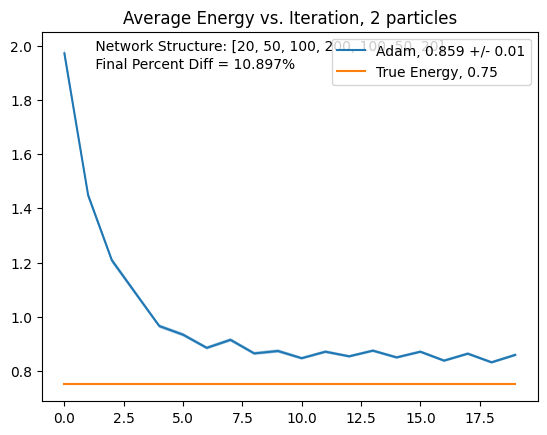

In [ ]:
true_energy = .5 * hbar * omega * num_particles
#g = 1, sigma = -g/2
true_energy = .75
# g = .1, sigma = 0:
# true_energy = 1.03881
# g= .8, sigma= -g
# true_energy = .9375

total_hists =  resultsa[0] + resultsb[0] 
#+ resultsc[0] + resultsd[0] + resultse[0]

# + resultsd[0]
total_uncerts = resultsa[1] + resultsb[1] 
#+ resultsc[1]  + resultsd[1] + resultse[1]
# + resultsd[1]

# get index of minimum value
min_val = np.min(total_hists)
min_index = total_hists.index(min_val)
min_err = total_uncerts[min_index]
val = gv.gvar(min_val, min_err)
fractional_error = (val - true_energy)/true_energy
print("Minimum value: ", val)
print("Fractional error: ", fractional_error)

plt.plot(np.arange(0, len(total_hists)), total_hists, label="Adam, " + str(round(total_hists[-1],3)) + " +/- " + str(round(total_uncerts[-1], 2)))
# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# get the network structure
structure = nn.hidden_sizes
plt.annotate(" Network Structure: " + str(structure), xy=(0.1, 0.95), xycoords='axes fraction')
plt.plot(np.arange(0, len(total_hists)), [true_energy for x in np.arange(0, len(total_hists))], label=r"True Energy, " + str(round(true_energy,3)))
pdiff = (min_val - true_energy)/true_energy*100
plt.annotate(" Final Percent Diff = " + str(round(pdiff,3)) + "%", xy=(.1, .9), xycoords= 'axes fraction')
plt.legend()
plt.title("Average Energy vs. Iteration, " + str(num_particles) + " particles")
plt.show()

In [ ]:
xs = np.arange(-5, 5, .05)
ys = np.arange(-5, 5, .05)
wavs = []
for i in range(len(xs)):
    for j in range(len(ys)):
        wavs.append(psi(np.array([xs[i], ys[j]]), resultsc[3])**2)


In [ ]:
X, Y = np.meshgrid(xs,ys)
Z = np.array(wavs).reshape(len(xs), len(ys))

In [ ]:
fig = plt.figure()
plt.contourf(X, Y, Z, 100)
plt.plot(xs,-xs)
plt.grid()
plt.show()